<a href="https://colab.research.google.com/github/Sumedhachak/creditCardDefaulters/blob/main/pegasus-xmus_implem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install transformers==4.17.0

     |████████████████████████████████| 3.8 MB 10.0 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0


In [1]:
!pip install pyspellchecker

In [2]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

### Examples

In [8]:
## The last two examples are from the Pegasus paper: https://arxiv.org/pdf/1912.08777.pdf
src_text = [
    """ PG&E stated it scheduled the blackouts in response to forecasts for high winds amid dry conditions. 
    The aim is to reduce the risk of wildfires. Nearly 800 thousand customers were scheduled to be affected by the shutoffs which were expected to last through at least midday tomorrow.""",
    """She will play Denker, a lady’s maid to Dame Maggie Smith’s character, the Dowager Countess of Grantham. Johnston, who has also appeared in
Waking the Dead and Coronation Street, joins new stars Richard E Grant and Anna Chancellor, both of whom will play guests of the Granthams
at Downton. The hit period drama will return to screens this autumn. Series four of the show, which followed the wealthy Grantham family and
their servants, achieved an average of 11.9 million viewers in the UK. The very British drama has also been a huge hit in the US, winning both
Emmy Awards and Golden Globes. More than 26 million viewers watched series four on Masterpiece on PBS, making it one of the highest rating
shows on American television. Previous high profile guest stars include Shirley Maclaine who played Martha Levinson, Lady Grantham’s mother,
and Oscar-nominated actor Paul Giamatti who appeared in last year’s Christmas special as her ”maverick, playboy” son. Series five will also feature
24 star Rade Sherbedgia as a Russian refugee who has fled the revolution after World War 1. Earlier this year, executive producer Gareth Neame
promised it would have ”all the usual highs and lows, romance, drama and comedy”""",
    """Matthew Gillard, of Connsbrook Avenue in east Belfast, pleaded not guilty to charges including kidnapping and false imprisonment. The defendant,
25, also denied charges of common assault, assaulting a police officer and driving dangerously. The charges relate to incidents in east Belfast and
Comber on Saturday 4 April. Newtownards Magistrates Court heard that the defendant and the woman were in his car in east Belfast when he
began questioning her about who she was seeing. A detective giving evidence in court said the woman tried to get out of the Seat Toledo car but the
defendant allegedly drove off at speed, through a red light on Bloomfield Avenue. When the car stopped on the Belfast Road in Comber, the woman
escaped along a lane but was carried back to the car by the defendant, the court heard. An off-duty police sergeant saw this and went to help the
woman. When the sergeant tried to intervene, the defendant allegedly drove his car at the officer, forcing him to get out of the way. The sergeant was
able to pull the keys from the ignition through the car’s open window, but the defendant wrenched them from his grasp. He then drove to the Grand
Parade area of east Belfast where the woman was released. He is also alleged to have sent the woman a message threatening that if she went to police
about the incident he would ”ruin her life in every possible way”. The court heard that the defendant handed himself over to police on Wednesday,
despite being aware since Saturday that he was wanted by the PSNI. But during police interviews he refused to answer questions put to him. An
application for bail was made but this was refused. Mr Gillard will appear again in court on 1 May."""
]

In [4]:
model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!pip install sentencepiece

In [6]:
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [11]:
#batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest').to(torch_device)
batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest', return_tensors='pt').to(torch_device)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3524: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [12]:
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)

In [13]:
for txt in tgt_text:
    print(txt)

California's largest electricity provider has turned off power to hundreds of thousands of customers.
Former EastEnders actress Janet Johnston has been cast as a guest star in the fifth series of Downton Abbey.
A man has appeared in court charged with kidnapping and assaulting a police officer.


### Pipelines

In [14]:
from transformers import pipeline

In [15]:
nlp_summary = pipeline('summarization', model=model, tokenizer=tokenizer)

In [16]:
nlp_summary(src_text[0])

Your max_length is set to 64, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


[{'summary_text': "California's largest electricity provider has turned off power to hundreds of thousands of customers."}]

### Wikipedia Random API

In [17]:
from urllib.request import urlopen
import json

def get_random_text():
    with urlopen('https://en.wikipedia.org/api/rest_v1/page/random/summary') as f:
        content = f.read().decode('utf-8')
        json_dict = json.loads(content)
        return json_dict['extract']

In [18]:
import pandas as pd

class StatsData():
    def __init__(self):
        self.inputs = []
        self.summaries = []
        self.input_length = []
        self.summary_length = []
        
    def add_text(self, input_text, summary):
        self.inputs.append(input_text)
        self.summaries.append(summary)
        self.input_length.append(len(input_text))
        self.summary_length.append(len(summary))
        
    def __repr__(self):
        return f'Stats data with total length: {len(self.inputs)}'
    
    def create_df(self):
        return pd.DataFrame({'input_text': self.inputs, 'summary': self.summaries, 'input_text_length': self.input_length, 'summary_length': self.summary_length})

In [19]:
from tqdm.notebook import tqdm

stats_data = StatsData()
required_summaries = 200
for i in tqdm(range(required_summaries), total=required_summaries):
    text = get_random_text()
    summary = nlp_summary(text)[0]['summary_text']
    if len(text) > 120 and len(text) < 600:
        stats_data.add_text(text, summary)
    

  0%|          | 0/200 [00:00<?, ?it/s]

Your max_length is set to 64, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 64, but you input_length is only 23. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 64, but you input_length is only 62. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 64, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 64, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 64, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 64, but you input_length is only 34. You might consider decreas

In [20]:
summary_data = stats_data.create_df()

In [21]:
summary_data['summary_ratio'] = summary_data['summary_length'] / summary_data['input_text_length']

In [22]:
summary_data

,input_text,summary,input_text_length,summary_length,summary_ratio
0,Fountainhall railway station served the villag...,A former Borders railway station has been rest...,122,71,0.581967
1,Transfusion is the second EP by the Australian...,Transfusion is the second EP by the Australian...,280,71,0.253571
2,Ireland competed at the 1984 Summer Paralympic...,The 30th anniversary of Ireland's participatio...,239,122,0.510460
3,Ballymore Eustace is a small town situated in ...,Ballymore Eustace is a small town situated in ...,184,135,0.733696
4,Sally (Salomon) Ruben Henriques was a Jewish-D...,An exhibition of the work of one of Denmark's ...,135,97,0.718519
...,...,...,...,...,...
142,My Gear and Your Gown is a 2020 Thai televisio...,My Gear and Your Gown is a 2020 Thai televisio...,199,199,1.000000
143,Peter Stevenson Rummell is an American real es...,"Peter Rummell is the founder of One Spark, a c...",440,92,0.209091
144,Crime Investigation Australia is an Australian...,Crime Investigation Australia is an Australian...,282,143,0.507092
145,The Sudanese Shadow Government is a political ...,The Sudanese Shadow Government is a political ...,176,132,0.750000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Input Distribution / Summary Length Distribution')

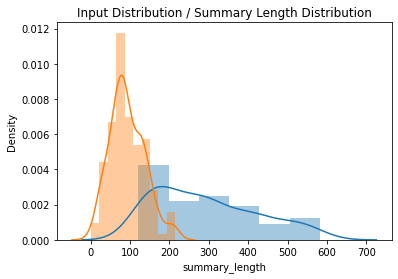

In [23]:
import seaborn as sb

sb.distplot(summary_data['input_text_length'])
sb.distplot(summary_data['summary_length']).set_title('Input Distribution / Summary Length Distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Summary Ratio Distribution')

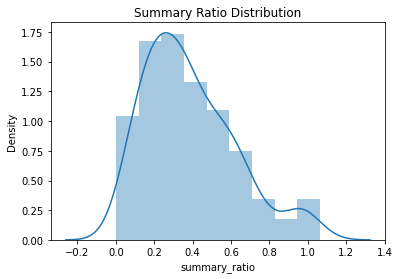

In [24]:
sb.distplot(summary_data['summary_ratio']).set_title('Summary Ratio Distribution')

In [25]:
f"Mean summary ratio: {summary_data['summary_ratio'].mean()}"

'Mean summary ratio: 0.3861570067314718'

### Spellchecking

In [26]:
import nltk
import re
from nltk.corpus import stopwords
import itertools
import collections

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
def remove_punctuation(txt):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [28]:
def clean_text(txt):
    """Removes punctuation, changes to lowercase, removes
        stopwords and calculates word frequencies.

    Parameters
    ----------
    txt : string
        A text string that you want to clean.

    Returns
    -------
    Words and frequencies
    """
    
    tmp = [remove_punctuation(t) for t in txt]
    tmp = [t.lower().split() for t in tmp]
    
    tmp = [[w for w in t if not w in stop_words]
              for t in tmp]
    
    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return list(tmp.keys())

In [29]:
summary_spell_check_words = clean_text(set(list(summary_data['summary'])))
input_text_check_words = clean_text(set(list(summary_data['input_text'])))

In [30]:
from spellchecker import SpellChecker

In [31]:
spell = SpellChecker()

# find those words that may be misspelled
summary_misspelled = spell.unknown(summary_spell_check_words)
original_misspelled = spell.unknown(input_text_check_words)
len(summary_misspelled), len(original_misspelled)

(197, 548)

In [32]:
f"Summary mispelled ratio: {len(summary_misspelled) / len(summary_spell_check_words)}"

'Summary mispelled ratio: 0.1942800788954635'

In [33]:
f"Original misspelled ratio: {len(original_misspelled) / len(input_text_check_words)}"

'Original misspelled ratio: 0.21044546850998463'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


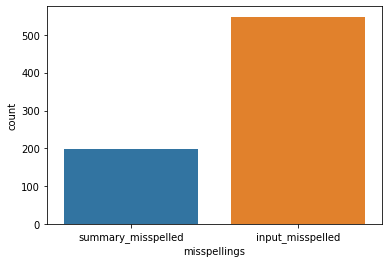

In [34]:
misspelling_df = pd.DataFrame({'misspellings' : ["summary_misspelled" for _ in range(len(summary_misspelled))] + ["input_misspelled" for _ in range(len(original_misspelled))]})

sb.countplot(misspelling_df['misspellings'])

### Generate HTML for Visual Proofreading

In [35]:
table_data = ""
for i, d in summary_data.iterrows():
    table_data += f"<tr><td>{d['input_text']}</td><td>{d['summary']}</td></tr>"

In [36]:
simple_visual_check = f"""
<html>
<body>
<table>
    <tr><th>Original</th><th>Input Text</th></tr>
    {table_data}
</table>
</body>
</html>
"""

In [37]:
with open('visual_check.html', 'w') as f:
    f.write(simple_visual_check)